
<h1><center> Group 9 </h1>  

<center>Name | Matriculation Number
:-: | :-:  
Liu ShaoMin | A0183798E
Mekala Hosur |  A0180563M
Yifan | A0177863M 
ZhiHao | A0182912E    
Michale | A0187151E  
</center>  

<br>
<hr>
<br>

## Objectives  

In this report, we aim to use the data to identify the new customers whom has only start to visit our outlets recently, and the purpose to win their hearts and **turn them into loyal customers**. 

In this report, we will be using Decision Tree techniques to retain new and churned customers. We will be using Random Forest Regressor and OneVsRest Tree Classifier to predict basket size and the decision to purchase a category out of the 64 categories available, respectively.

The second part of our report aims to prevent our existing customers from leaving our service. Machine learning techniques are applied to identify the characterstics of a soon-to-churn customers, we can them monitor the purchasing behaviour of our customers on a regular basis, a change in the important charaterstics may then signal that they are about to churn.

We will be going through these techniques in depth, using Mean Squared Error, False Negative Rate, and other evaluation techniques to fine tune our parameters. 

Once we can identify the customers who are likely to churn, we can then follow up with some interventions, reducing the likelihood of churning.  

## Models

In our report, we intend to use the following techniques to achive our intended objectives

* Regression Tree
* Decision Trees
* Recommendation Engines  


 ## Content  
 The following steps were followed in this report:  
* Packages
* Data
* New Customers Recommendation  
  * Identifying New Customers
  * Preparing Data
  * Predict Customer Purchase
  * Predict Purchase Quantity  
* Feature Engineering on churned data
* Classification Tree
  * Data Preparation  
    * RFM
    * Packsize
    * Demographic
  * Simple Decision Tree 
    * Benchmark model
    * Parameter Tunning  
  * Insights from Decision Tree
* Recommendations on customer Income & BMI 
* Summary  


# 1. Import Packages

In [1]:
import matplotlib.pyplot as plt
import graphviz 
import seaborn as sns 
import plotly.express as px
from plotnine import *

import pandas as pd
import numpy as np
from scipy import stats 

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.metrics import accuracy_score,f1_score,precision_score,roc_auc_score,recall_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import export_text

# 2. Import Data



In [2]:
from google.colab import drive
drive.mount('/content/drive')

# please change your desired directory here
location = '/content/drive/My Drive/DSA3101 Group 9/data/'

Mounted at /content/drive


In [3]:
# run the mount drive below
# put the data folder on the root directory of your google drive
df_catinfo = pd.read_csv(location + 'DSA3101_Hackathon_Categories_Information.csv')
df_hackdata= pd.read_csv(location + 'DSA3101_Hackathon_Data.csv', parse_dates=['Date'])
df_paneldemo = pd.read_excel(location + 'DSA3101_Hackathon_Panelists_Demographics.xlsx')

In [4]:
df_paneldemo['Ethnic'] = df_paneldemo.Ethnicity.apply(lambda x: x.split(" ")[-1])

# 3. Recommendations for New Customers

In this section, we target new customers because of they consist of a rather high proportion among all customers. For example, just in the year 2019, there are more than 500 new customer, which is approximately 30% of all customers. If we can turn new customer into loyal customer by recommend them things they want exactly, this can increase our revenue greatly.

For visual aid, here is a plot of new customers across the years in 2018 and 2019. We do not consider the year 2020 as it it holds rather incomplete data. From the plot, we can see that not only has the number of customers doubled from 2018 to 2019, the proportion has significantly increased. 

2018 is red in colour, and 2019 is represented by grey.

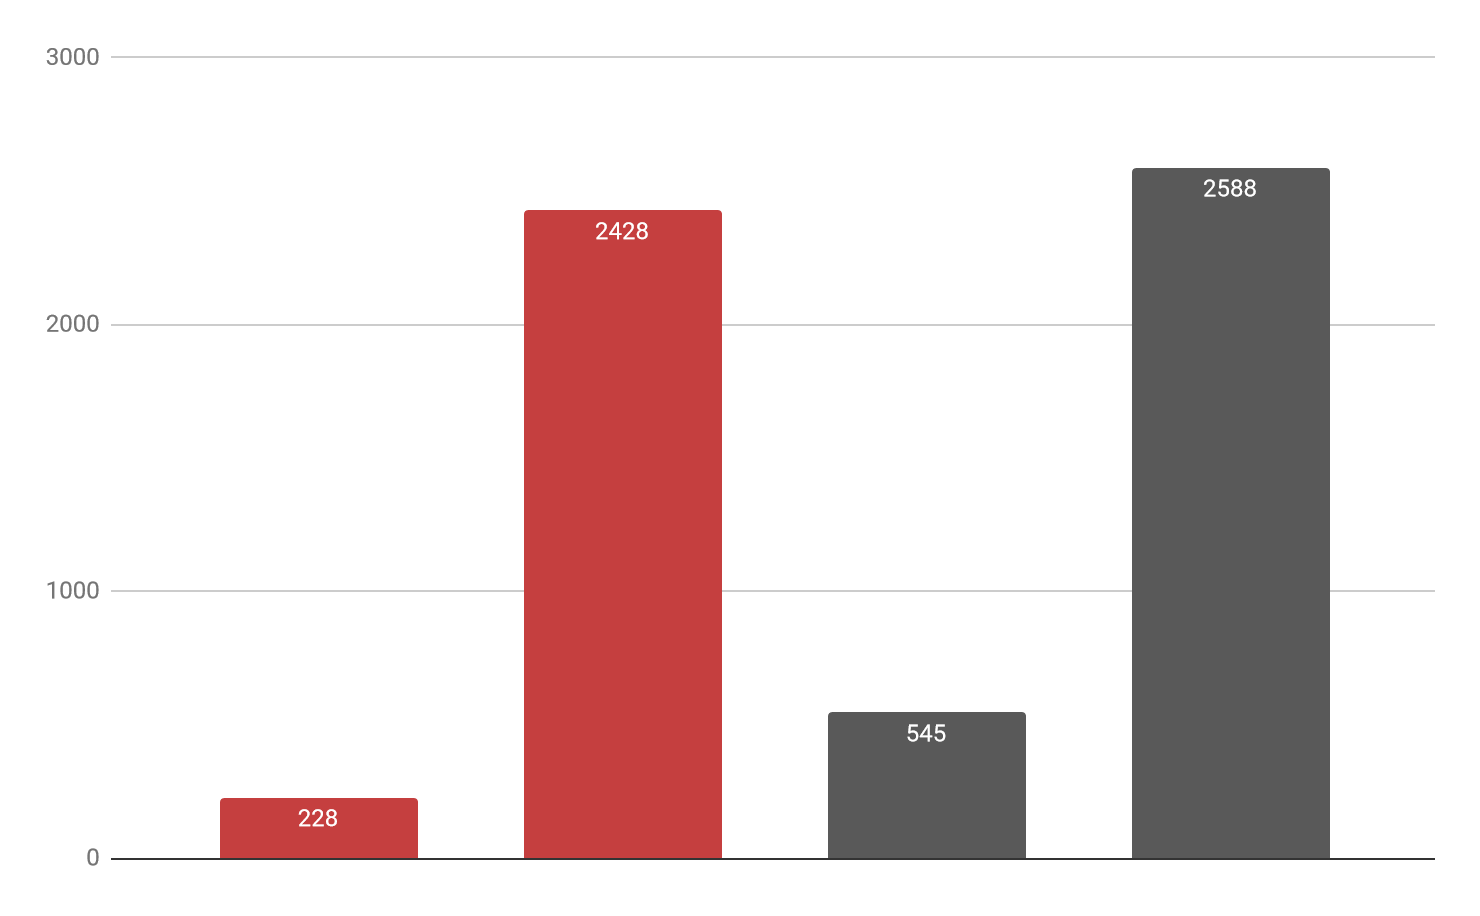

##3.1 Identifying new customers

In this section, we calculate the year in which a customer has joined our system. This is determined by the year their first transaction is made.





In [5]:
main = df_hackdata.copy()
dmg = df_paneldemo.copy()
dmg = dmg.rename(columns={'ID':'Panel ID'})
dmg.head()

,Panel ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,Ethnic
0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North,Malay
1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North,Malay
2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North,Malay
3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North,Chinese
4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North,Malay


In [6]:
panel_list = main.copy()["Panel ID"].unique().tolist()
import time
import datetime
df_coming = main.copy().groupby("Panel ID").min().reset_index().\
                                        loc[:,["Panel ID","Date"]]

def coming_year(df):
    if df["Date"]>=datetime.datetime.strptime("2020-01-01",'%Y-%m-%d').date():
        return 2020
    elif df["Date"]>=datetime.datetime.strptime("2019-01-01",'%Y-%m-%d').date():
        return 2019
    elif df["Date"]>=datetime.datetime.strptime("2018-01-01",'%Y-%m-%d').date():
        return 2018
    return 2017

df_coming["year"] = df_coming.apply(lambda row:coming_year(row),axis = 1)

In [7]:
df_demo = pd.merge(df_coming, dmg.copy(), on = ["Panel ID"]).drop(columns= "Date")
df_demo["Ethnicity"] = df_demo["Ethnicity"].apply(lambda x:x.split(" ")[-1])
df_demo.head()

,Panel ID,year,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,Ethnic
0,Panel 101011101,2017,Obese,Income 1500 - 1999,Malay,Empty Nesters,Urban,1-3 Member HH,North,Malay
1,Panel 101016101,2017,Healthy,Income 1500 - 1999,Malay,Teens Aches,Urban,1-3 Member HH,North,Malay
2,Panel 101019101,2017,Obese,Income < 1500,Malay,Teens Aches,Urban,4 Member HH,North,Malay
3,Panel 101024101,2017,Over Weight,Income 1500 - 1999,Chinese,Nesting Families,Urban,1-3 Member HH,North,Chinese
4,Panel 105009103,2017,Over Weight,Income < 1500,Malay,Empty Nesters,Rural,1-3 Member HH,North,Malay


##3.2 Preprocessing of Data for Decision Tree:
The original data in demographic is categorical data that cannot be identified in decision tree model, so we change categorical data to numerical using one_hot_encoding. (This transformation is exactly the same as section 4.)

In [8]:
df_panel_cats = df_demo.apply(lambda x: pd.Series(x.unique()[0:12]), axis = 0).fillna('').iloc[:,1:]

dict_bmi = dict(zip(df_panel_cats.BMI[df_panel_cats.BMI != ''].tolist(),
               (1, 4, 2, 3, 0)))
dict_income = dict(zip(df_panel_cats.Income[df_panel_cats.Income != ''].tolist(),
               (1750, 1000, 2500, 4500, 3500, 5500)))
dict_strata = dict(zip(df_panel_cats.Strata[df_panel_cats.Strata != ''].tolist(),
               (0, 1)))
dict_hh = dict(zip(df_panel_cats['#HH'][df_panel_cats['#HH'] != ''].tolist(),
               (2, 4, 7, 5, 6)))

def convert_with_dict(dict_):
    def convertor(x):
        return dict_[x]
    return convertor

In [9]:
df_panelconvert = df_demo.copy()

# numerical levels
df_panelconvert['BMI'] = df_panelconvert.BMI.apply(convert_with_dict(dict_bmi))
df_panelconvert['Income'] = df_panelconvert.Income.apply(convert_with_dict(dict_income))
df_panelconvert['Strata'] = df_panelconvert.Strata.apply(convert_with_dict(dict_strata))
df_panelconvert['#HH'] = df_panelconvert["#HH"].apply(convert_with_dict(dict_hh))

In [10]:
# One-Hot conversion
onehot_lifestage = pd.get_dummies(df_panelconvert.Lifestage, prefix='Lifestage')
df_panelconvert[onehot_lifestage.columns.tolist()] = onehot_lifestage

onehot_location = pd.get_dummies(df_panelconvert.location, prefix='location')
df_panelconvert[onehot_location.columns.tolist()] = onehot_location

onehot_ethnic = pd.get_dummies(df_panelconvert.Ethnic, prefix='ethnic')
df_panelconvert[onehot_ethnic.columns.tolist()] = onehot_ethnic

We will eventually be feeding all these various demographic features into both a regression and a multi-label decision tree, hence, it is important to check if there is any correlation between the features. If features are unexpectedly correlated, there is a need for us to consider removing one of them. 

Inside the below correlation plot, most features are not related. Only Ethnic others, Malay and Chinese are highly corelated. However, this is to be expected, as majority of the demographics in our dataset are Malay individuals, hence, the other two would be conversely, low in numbers. 

Therefore, we conclude that including all the features in our trees would be reasonable. 


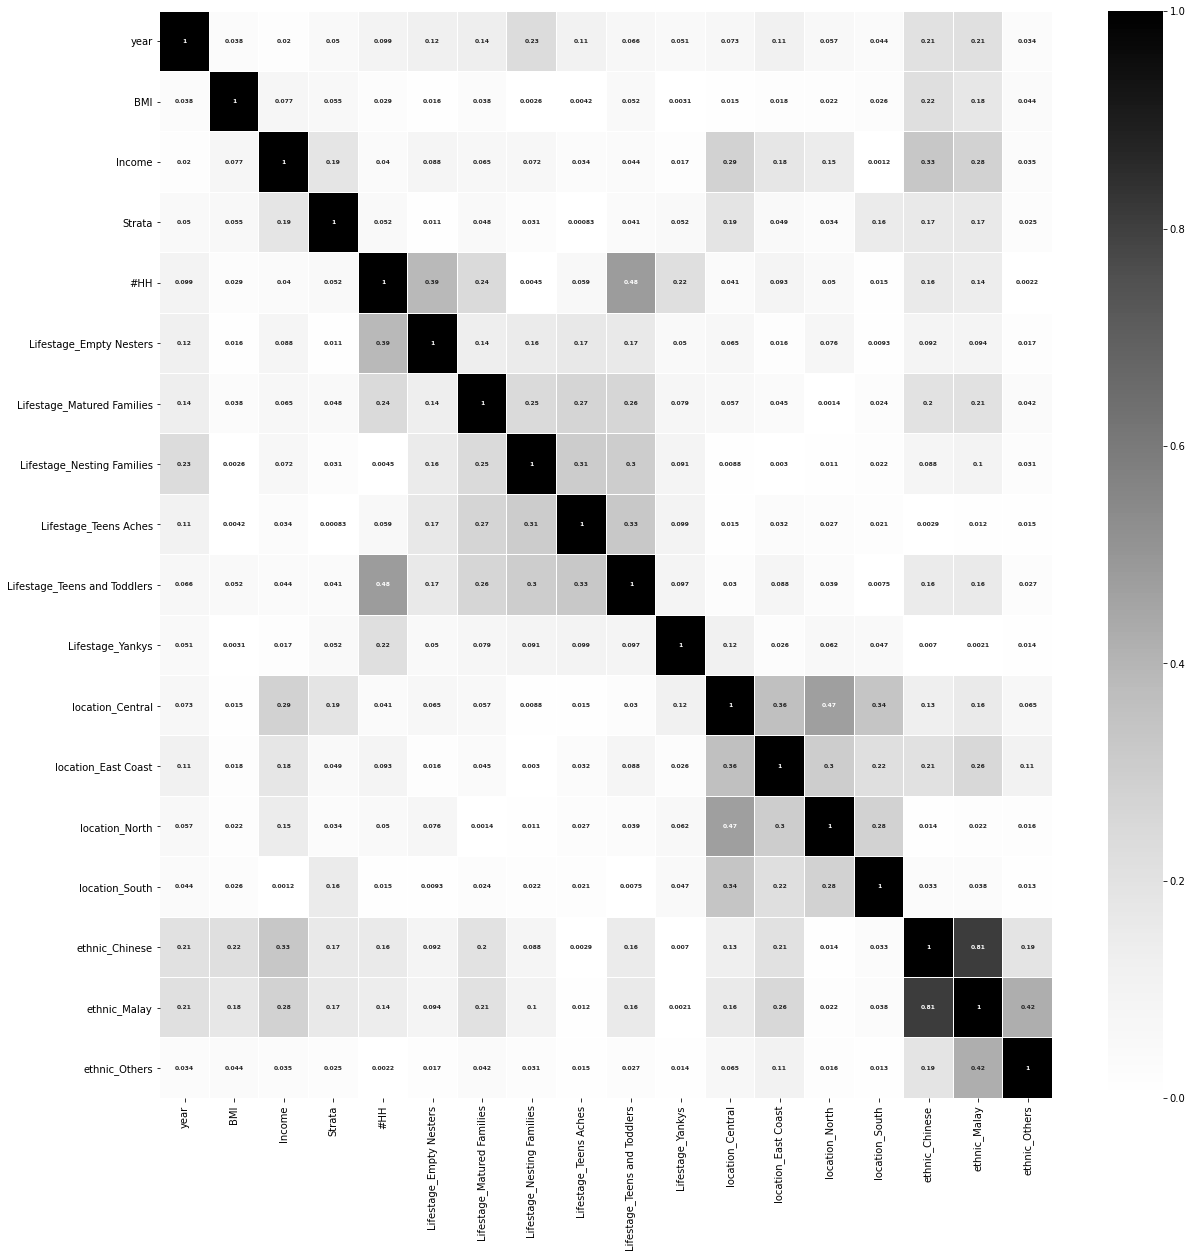

In [11]:
corr_df = df_panelconvert.copy()
correlation = abs(corr_df.corr())

fig = plt.figure(figsize = (20,20))
ax = sns.heatmap(correlation,cmap=plt.cm.Greys, linewidths=0.05,vmax=1, vmin=0 ,annot=True,annot_kws={'size':6,'weight':'bold'})

The original buying history are transformed into a pivot table, and we can track the exact amount of money spent per category.

In pivot2, we only track whether a customer has or has not bought each product in their transactions.

In pivot3, biscuits data are joined with demographics data. Therefore, we are almost ready to find the trend between demographic and products.

In [12]:
size_df = main.copy().groupby(["Panel ID","Category"]).size().reset_index()# sum/size
size_pivot = size_df.pivot(index='Panel ID', columns='Category', values=0)
size_pivot = size_pivot.fillna(0)

In [13]:
pivot2 = size_pivot.copy()
cate_list = size_pivot.columns.tolist()
for i in cate_list:
    pivot2[i] = size_pivot[i].apply(lambda row:1 if row>0 else 0)

In [14]:
pivot3 = pd.merge(pivot2["Biscuits"], df_panelconvert, on = ["Panel ID"])

Using the pivot3 dataframe, we want to construct one binary classification tree to explore whether or not it is possible to predict if a new customer wants to buy "Biscuits", for instance. This is purely for exploratory purposes. In section 3.4, we will carry out a multi-label classification for all 62 food categories. 

In [15]:
feature_col = pivot3.columns.tolist()
feature_col.remove("Panel ID")
feature_col.remove("Biscuits")
feature_col.remove("year")
feature_col.remove("Lifestage")
feature_col.remove("Ethnicity")
feature_col.remove("Ethnic")
feature_col.remove("location")

Spliting dataframe into test set (30% of the original dataset) and training set, X is a particular customer's demographic and y is whether the customer has bought biscuits. 
Since this is purely exploratory and a demonstration, we did not put effort to improve it. 


In [16]:
X_train, X_test, y_train, y_test = train_test_split(pivot3[feature_col], 
                                                    pivot3['Biscuits'], 
                                                    test_size=0.3, random_state=13, shuffle = True)
cate_list = main.copy()["Category"].unique().tolist()

In [17]:
clf = DecisionTreeClassifier(random_state=8,max_depth = 20, criterion ="gini")
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [18]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
cm#

,True Y=0,True Y=1
Predicted Y=0,14,95
Predicted Y=1,67,795


##2.3 Prediction for each Food Category: A multi-label model

For each customer, we try to predict his consumption of each category, this becomes a multi-label model where each product is a label. We use OneVsRest to solve the multi-label problem, where each model inside independently predicts whether a particular new customer will or will not buy a particular product.

As this is a classification problem, we will be using the F1 score to evaluate our model. The higher the F1 score, it means our classifier is able to correctly identify a item bought.

In [19]:
pivot4 = pd.merge(df_coming, pivot2, on = ["Panel ID"]).drop(columns = "Date")
pivot4 = pd.merge(pivot4, df_panelconvert, on = ["Panel ID"])

Similar to the earlier exploratory simple decision tree model, we split the dataset into a train and test set consisting of 30% of the data. The 

In [20]:
X_values = pivot4[feature_col]
Y_values = pivot4.drop(columns = ['Panel ID', 'year_x','year_y', 'BMI', 'Income',
       'Ethnicity', 'Lifestage', 'Strata', '#HH', 'location', 'Ethnic',
       'Lifestage_Empty Nesters', 'Lifestage_Matured Families',
       'Lifestage_Nesting Families', 'Lifestage_Teens Aches',
       'Lifestage_Teens and Toddlers', 'Lifestage_Yankys', 'location_Central',
       'location_East Coast', 'location_North', 'location_South',
       'ethnic_Chinese', 'ethnic_Malay', 'ethnic_Others'])

X_train, X_test, y_train, y_test = train_test_split(X_values, 
                                                    Y_values, 
                                                    test_size=0.3, random_state=13, shuffle = True)

X_train.head()

,BMI,Income,Strata,#HH,Lifestage_Empty Nesters,Lifestage_Matured Families,Lifestage_Nesting Families,Lifestage_Teens Aches,Lifestage_Teens and Toddlers,Lifestage_Yankys,location_Central,location_East Coast,location_North,location_South,ethnic_Chinese,ethnic_Malay,ethnic_Others
971,4,3500,0,6,0,0,0,1,0,0,1,0,0,0,1,0,0
2176,4,2500,0,4,0,0,0,1,0,0,0,1,0,0,1,0,0
2361,4,2500,1,5,0,0,0,1,0,0,0,0,1,0,0,1,0
1891,4,5500,0,4,0,0,1,0,0,0,1,0,0,0,1,0,0
3161,4,1750,0,5,0,0,1,0,0,0,1,0,0,0,0,1,0


Taking a look at the below, we look at the decision tree classification micro F1 score which is 0.6474. 

In [21]:
dtr = OneVsRestClassifier(DecisionTreeClassifier(random_state=8,criterion='gini')).\
            fit(X_train,y_train)

y_prediction = dtr.predict(X_test)
f1_score(np.array(y_test),np.array(y_prediction),average = "micro")

0.6474365797409969

We now try the same problem, but with a random forest classifier. With a default setting, the random forest (F1 score of 0.695) performs better than the decision tree (0.65), and we can further see if it improves with more parameter tuning. 

In [22]:
rfc = OneVsRestClassifier(RandomForestClassifier(random_state=8))
y_pred2 = rfc.fit(X_train,y_train).predict(X_test)
f1_score(np.array(y_test),np.array(y_pred2),average = "micro")

0.6948652840027949

We can first take a look at the parameter max_depth to improve this. 

In [23]:
# This piece of code takes a long time to run. 

index = []
osr_imp = []
for i in range(2,15):
    y_pred = OneVsRestClassifier(RandomForestClassifier(random_state=8,criterion='gini',max_depth = i)).\
            fit(X_train,y_train).predict(X_test)
    osr_imp.append(f1_score(np.array(y_test),np.array(y_pred),average = "micro"))
    index.append(i)

From the below, we can see that the best F1 score (0.733858) is acheived at a max_depth of 5. 

In [24]:
imp = {"index":index, "osr_imp": osr_imp}
imp = pd.DataFrame(imp)
imp.head()

,index,osr_imp
0,2,0.728828
1,3,0.731191
2,4,0.733009
3,5,0.733858
4,6,0.733614


Next, we can choose to determine the best n_estimator value that we can tune for our random forest classifer. A note that we tried to tune or min_sample_split value, but it didn't change the best F1 score we have so far from the max_depth training, hence we have not included the tuning part for it in our code here. 

In [25]:
# This piece of code takes a long time to run. 

index = []
osr_imp = []
for i in range(2,150,10):
    y_pred = OneVsRestClassifier(RandomForestClassifier(random_state=8,criterion='gini',max_depth = 5, n_estimators = i)).\
            fit(X_train,y_train).predict(X_test)
    osr_imp.append(f1_score(np.array(y_test),np.array(y_pred),average = "micro"))
    index.append(i)

From the below, we can see that the best F1 score (0.734007) is achieved at a n_estimator value of 92 (approximately). 

In [26]:
imp = {"index":index, "osr_imp": osr_imp}
imp = pd.DataFrame(imp)
imp.tail(6)

,index,osr_imp
9,92,0.734007
10,102,0.733549
11,112,0.733401
12,122,0.733855
13,132,0.733947
14,142,0.733944


Hence, this is the final multi-label classification that we have decided on, which is a random forest classifer that has max_depth of 5, a min_sample_split = 2 and a n_estimator value of 92. The F1 score has improved from the default 0.695 to 0.734. 

In [27]:
rfc2 = OneVsRestClassifier(RandomForestClassifier(random_state=8, max_depth = 5, min_samples_split = 2, n_estimators = 92))
y_pred2 = rfc2.fit(X_train,y_train).predict(X_test)

f1_score(np.array(y_test),np.array(y_pred2),average = "micro")

0.7340068504999481

There are some issues with this model, however. 

Looking at the below, inside this classification model, the model predict some products such as Tonic Food Drink pretty well, and at the same time preforms badly at some products such as Spirits. Hence, we only keep categories that have a F1 score of equal to or better than 0.4. Those products that do not meet this criterion will not be included in our recomended list to the new customers. 

In [28]:
rep = classification_report(np.array(y_test),np.array(y_pred2),target_names = sorted(cate_list))
print(rep)

                     precision    recall  f1-score   support

        Baby Cereal       0.00      0.00      0.00        83
               Beer       0.57      0.03      0.05       139
            Belacan       0.00      0.00      0.00       223
          Bird Nest       0.00      0.00      0.00        35
           Biscuits       0.92      1.00      0.96       890
            Bouilon       0.69      0.80      0.74       598
             Butter       0.59      0.37      0.46       421
                CSD       0.59      0.69      0.64       520
               Cake       0.54      0.04      0.07       391
     Canned Product       0.76      1.00      0.86       739
    Cereal Beverage       0.62      0.70      0.66       534
            Cereals       0.56      0.54      0.55       482
             Cheese       0.63      0.37      0.47       386
    Chicken Essence       0.00      0.00      0.00        92
    Choc/Nut Spread       0.00      0.00      0.00       240
          Chocolate    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [29]:
pred_list = ["Biscuits", "Bouilon", "Butter", "CSD", "Canned Product", "Cereal Beverage", "Cereals", "Cheese", "Chocolate", 
             "Coconut Milk", "Coffee", "Condensed/Evap Milk", "Confectionery", "Cooking Oils", "Cooking Sauces", "Cordials", 
             "Cultured Milk", "Eggs", "Flour", "Frozen Food", "Fruit/Veg Juices", "Ice Cream", "Instant Noodles", "Isotonic Drinks", 
             "Liquid Milk", "Margarine", "Milk Powder-Adult", "Milk Powder-Kids", "Peanut Butter", "Rice", "Salad Dressing", 
             "Seasoning Powder", "Snack", "Soy Milk", "Spagetti", "Sugar", "Tea", "Tonic Food Drink", "Yoghurts"]

##3.4 Predicting basket size for a New Customer

After understanding what products our new customer would like to purchase, we need to decide how many items we should recommend. We feed the demographics of the new customer we want to target into the regression tree, and the label we wish to predict is the basket size of a transaction. To prevent bias of the basket size, our y labels are only the average basket size of the first transaction. If we do not do this, bias might be induced in the form of a more loyal customer gradually buying more items as time progresses.

In [30]:
transaction = main.copy().groupby(["Panel ID", "Date"]).size().reset_index().rename(columns={0:"size"})
first_trans = pd.merge(df_coming, transaction, how = "left",on=["Panel ID","Date"])
first_trans = pd.merge(first_trans, df_panelconvert, on = ["Panel ID"])

X_values = first_trans[feature_col]
Y_values = pd.DataFrame(first_trans['size'])

In [31]:
X_train_clf = X_values.iloc[X_train.index.values, :] # same indexes as previously split from the regression tree
y_train_clf = Y_values.iloc[X_train.index.values, :]

input_test = X_values.iloc[X_test.index.values, :]
output_test = Y_values.iloc[X_test.index.values, :]

We further split the training set that we have into a validation and new training set so that we can use the validation set to estimate parameter fine-tuning.

As this is a regression problem, we will be using Mean Squared Error as our evaluation metric for our model's performance. The lower the MSE, the better our model.


In [32]:
input_train, input_valid, output_train, output_valid = train_test_split(X_train_clf, y_train_clf, test_size=0.2, 
                                                                        random_state=13, shuffle = True)

If we were to take a look at the mean-squared error of the decision tree regressor (DTR) on the training set, the MSE value is 5.968, however the validation MSE value is much higher at 35.74. The DTR is definitely overfitting greatly on the training set. 

In [33]:
reg_tree_pack = DecisionTreeRegressor(random_state = 13, max_depth = 3) 
reg_tree_pack.fit(input_train, output_train) 
output_valid_pred = reg_tree_pack.predict(input_valid)
output_train_pred = reg_tree_pack.predict(input_train)

print(mean_squared_error(output_train,output_train_pred))

29.133500201965397


[Text(167.4, 190.26, 'X[14] <= 0.5\nmse = 31.042\nsamples = 1812\nvalue = 5.73'),
 Text(83.7, 135.9, 'X[3] <= 4.5\nmse = 37.537\nsamples = 1336\nvalue = 6.358'),
 Text(41.85, 81.53999999999999, 'X[6] <= 0.5\nmse = 19.009\nsamples = 625\nvalue = 5.421'),
 Text(20.925, 27.180000000000007, 'mse = 16.904\nsamples = 449\nvalue = 5.207'),
 Text(62.775000000000006, 27.180000000000007, 'mse = 23.965\nsamples = 176\nvalue = 5.966'),
 Text(125.55000000000001, 81.53999999999999, 'X[3] <= 5.5\nmse = 52.374\nsamples = 711\nvalue = 7.181'),
 Text(104.625, 27.180000000000007, 'mse = 26.496\nsamples = 300\nvalue = 6.52'),
 Text(146.475, 27.180000000000007, 'mse = 70.71\nsamples = 411\nvalue = 7.664'),
 Text(251.10000000000002, 135.9, 'X[11] <= 0.5\nmse = 8.596\nsamples = 476\nvalue = 3.966'),
 Text(209.25, 81.53999999999999, 'X[12] <= 0.5\nmse = 8.263\nsamples = 451\nvalue = 3.889'),
 Text(188.32500000000002, 27.180000000000007, 'mse = 8.336\nsamples = 307\nvalue = 4.075'),
 Text(230.175, 27.180000000

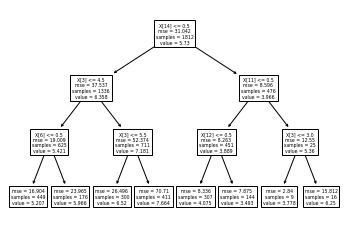

In [34]:
from sklearn import tree
tree.plot_tree(reg_tree_pack)

In [35]:
input_train.columns

Index(['BMI', 'Income', 'Strata', '#HH', 'Lifestage_Empty Nesters',
       'Lifestage_Matured Families', 'Lifestage_Nesting Families',
       'Lifestage_Teens Aches', 'Lifestage_Teens and Toddlers',
       'Lifestage_Yankys', 'location_Central', 'location_East Coast',
       'location_North', 'location_South', 'ethnic_Chinese', 'ethnic_Malay',
       'ethnic_Others'],
      dtype='object')

In [36]:

tree.export_graphviz(reg_tree_pack,
                     out_file="tree.dot",
                     feature_names = input_train.columns, 
                     filled = True)

In [37]:
print(mean_squared_error(output_valid,output_valid_pred))

17.43397044087005


Random forests, like the classification one we used before, are rather good in balancing the variance since it performs bagging and allows resampling to ensure that overfitting is kept to a minimum. 

We can now take a look at the mean-squared error of the random forest regressor (RFR) on the training set. The validation MSE has significantly dropped from 35.74 to 27.76, hence, we would like to employ the random forest regressor instead of the decision tree. 

In [38]:
reg_tree_pack = RandomForestRegressor(random_state = 13) 
reg_tree_pack.fit(input_train, output_train.values.ravel()) 
output_valid_pred = reg_tree_pack.predict(input_valid)
output_train_pred = reg_tree_pack.predict(input_train)

print(mean_squared_error(output_train,output_train_pred))

9.87170414098646


In [39]:
print(mean_squared_error(output_valid,output_valid_pred))

27.76096850149023


One way to improve the performance of the RFR would be to filter only the important features out for the X features. If we were to take a look at the below, we have BMI, Income, #HH, Strata as the most important features, after which the feature importance significantly drop.

We have tried dropping irrelevant features from our model, however, this attempt did not prove to be helpful in reducing MSE values. 

In [40]:
pd.DataFrame(features,reg_tree_pack.feature_importances_ ).sort_index(ascending = False).head()

NameError: ignored

Another way we can choose to improve our MSE values is to do parameter tuning for our RFR. The first one that we attempt on is the max_depth. 

In [41]:
max_dep = []

mse_train= []
mse_test =[]

mse_valid = []

for i in range(2,20):
    max_dep.append(i)
    dtr = RandomForestRegressor(random_state=30, max_depth=i) 
    dtr.fit(input_train, output_train.values.ravel()) 
    
    output_test_pred = dtr.predict(input_test)
    output_train_pred = dtr.predict(input_train)
    output_valid_pred = dtr.predict(input_valid)

    for j in output_test_pred:
        j = round(j,0)

    mse_train.append(mean_squared_error(output_train,output_train_pred))
    mse_valid.append(mean_squared_error(output_valid,output_valid_pred))
    mse_test.append(mean_squared_error(output_test,output_test_pred))

In the below graph, we plot the max_depth against all the 3 different MSE values we want to predict (validation, train, test). However, we will not be looking at the test results to decdide the max_depth but instead the train and especially, the validation results. 

If we take a look at the graph, we realise that the train_mse is initally higher than the validation MSE, and this can be attributed to the fact that the RFR will extend max depth until a minimum MSE can be hit for the training set. However, we can see from the graph that it would be more beneficial for us to stop the tree from growing much earlier, at perhaps a max_depth of 3. 

Beyond this, i.e max-depth, we also attempted to tune parameters such as min_samples_split and n_estimators, but there was not much change in the MSE values, hence, we have decided not to include them in our report. 

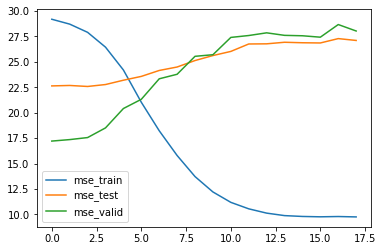

In [42]:
imp = {"max_dep":max_dep, "mse_train":mse_train, "mse_test":mse_test, "mse_valid":mse_valid}
pd.DataFrame(imp)
plt.plot(mse_train,label = "mse_train")
plt.plot(mse_test,label = "mse_test")
plt.plot(mse_valid,label = "mse_valid")
plt.legend()

In [43]:
pd.DataFrame(imp).head()

,max_dep,mse_train,mse_test,mse_valid
0,2,29.173526,22.625469,17.206527
1,3,28.694249,22.669083,17.352344
2,4,27.888254,22.570242,17.551974
3,5,26.432111,22.760276,18.501986
4,6,24.187981,23.184344,20.404490


The below gives our final test MSE loss values for the RFR model we have chosen, which is approxmiately 23 and we are off our mark of predicting first purchase basket size, by about 4 items. We believe that this can be further improved in the future with better models, and that our recomendation engine's value can be heightened.  

In [44]:
rfr = RandomForestRegressor(random_state=30, max_depth=3) 
rfr.fit(input_train, output_train.values.ravel())

output_test_pred = rfr.predict(input_test)
mean_squared_error(output_test,output_test_pred)

22.66908319931739

##2.4 Recommendation
Based on basket size, bmi, and category info, we can now do our recommendation. The recommended list is retricted by basket size basked on categories new customer may purchase. We also provide a low calories focused basket for customers who are interested.

In [45]:
product_info = df_catinfo.copy()
calory = product_info.sort_values(by = "Calories/100g",ascending=True)
price = product_info.sort_values(by = "Price per Volume",ascending=False)

In [46]:
test_df = pivot3.iloc[X_test.index.values, :]
test_df.head()

,Panel ID,Biscuits,year,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,Ethnic,Lifestage_Empty Nesters,Lifestage_Matured Families,Lifestage_Nesting Families,Lifestage_Teens Aches,Lifestage_Teens and Toddlers,Lifestage_Yankys,location_Central,location_East Coast,location_North,location_South,ethnic_Chinese,ethnic_Malay,ethnic_Others
2244,Panel 800448601,1,2017,3,2500,Malay,Teens and Toddlers,1,7,Central,Malay,0,0,0,0,1,0,1,0,0,0,0,1,0
1634,Panel 421022101,1,2017,1,3500,Malay,Teens and Toddlers,0,6,East Coast,Malay,0,0,0,0,1,0,0,1,0,0,0,1,0
1142,Panel 248064101,1,2017,2,1000,Malay,Empty Nesters,0,2,Central,Malay,1,0,0,0,0,0,1,0,0,0,0,1,0
29,Panel 106023104,1,2017,2,2500,Chinese,Teens Aches,0,6,North,Chinese,0,0,0,1,0,0,0,0,1,0,1,0,0
2726,Panel 801481501,1,2019,4,4500,Chinese,Matured Families,0,5,Central,Chinese,0,1,0,0,0,0,1,0,0,0,1,0,0


In [47]:
dtc = OneVsRestClassifier(RandomForestClassifier(random_state=8, max_depth = 5, min_samples_split = 2, n_estimators = 92)).\
fit(X_train, y_train)

In [48]:
def new_customer_recommendation(uid, will, model):#willness
    uid_x = test_df[test_df["Panel ID"]==uid].loc[:,feature_col]
    uid_pred  = model.predict(uid_x)
    uid_size =  round(rfr.predict(uid_x)[0],0)
    pred_df = pd.DataFrame(uid_pred,columns = sorted(cate_list))
    
    id_product_pred = pred_df[pred_list]
    id_dict = id_product_pred.to_dict()
    key=id_dict.keys()
    id_true_dict = id_dict.copy()
    for k in key:
        if id_dict[k]=={0:1}:
            id_true_dict[k] = 1
        else: del id_true_dict[k]
    
    id_info_dict = id_true_dict.copy()
    for k in id_true_dict.keys():
        temp = product_info[product_info["Category"]==k]
        id_info_dict[k] = [int(temp["Calories/100g"]), int(temp["Price per Volume"])]
    
    n = min(len(id_true_dict), int(uid_size))
    
    cal_dict = sorted(id_info_dict, key = lambda x:id_info_dict[x][0])
    price_dict = sorted(id_info_dict, key = lambda x:id_info_dict[x][1],reverse = True)

    if will==True:
      return {"id":uid, "cal": cal_dict[0:n], "pri": price_dict[0:n]}
    else:
      return {"id":uid, "pri": price_dict[0:n]}

If we look at the below panelist, this panelist has indicated that they do not want a low calorie basket hence, they only have one basket recommended to them. An interesting thing to note also is said panelist has 6 people in their family and belongs to a nesting family. This is reflected in their basket as well, which includes Milk-Powder-Kids which is actually not something that would appear under most panelists' reccomendation (you can refer to the next panelist example that we have for instance). 

In the output, 'pri' is referenced as the primary basket.

In [49]:
print(new_customer_recommendation("Panel 202133101",True, dtc))# person with a high bmi

{'id': 'Panel 202133101', 'cal': ['Coffee', 'Isotonic Drinks', 'CSD', 'Soy Milk'], 'pri': ['Chocolate', 'Cheese', 'Confectionery', 'Cereals']}


The next example we have is of someone that is of high bmi, and have 2 recomended basket of goods. The low calorie basket indicated by 'cal' is signifcantly loaded with items that are not in high calories. We can compare this to the primary basket that includes chocolate, and confectionary for example. 

In [51]:
print(new_customer_recommendation("Panel 403042101",False, dtc))# person with a low bmi 

{'id': 'Panel 403042101', 'pri': ['Chocolate', 'Tea', 'Milk Powder-Kids', 'Confectionery', 'Bouilon', 'Cereals', 'Coffee', 'Snack']}


# 3. Idenitifying "Churned" Customers  

In this section, we interested in finding out the predictors of  those churning, using the Decision Tree Classifier. 

For example, if decision tree shows that customers who made purchase on "product X" tends to churn, it is likely that the purchase on "product X" can serve as a warning sign of churn. This then suggest that we can device strategies to retain the customers.

**Feature Engineering**  
There is a very significant challenge in using Decision Tree to predict the outcome, that is, we are **not provided with the "churn" data** for each Panelist(customer). Therefore, we are using the following rules to simulate the churning behaviour of each Panelist.  

We only use the data up to the year 2019(excluding 2020 because 2020 data is incomplete) and we use information from the year 2018 to look for customer who has visited us in the past and see if they appear in 2019. If not, they are considered as churned.  


<center>Example:  </center> 
<center>Customers who appeared in 2018 & before = {A, B, C}</center> 
<center>Customers who appeared in 2019 = {A, D}  </center> 

Customer | Churned  
 :--: | :--:  
 A | 0  
 B | 1  
 C | 1
 D | 0   
  

In [ ]:
# create a copy so that the original df is not altered
df_hackdata_tree = df_hackdata.copy()
# only use data 2019 and before
df_hackdata_tree = df_hackdata_tree[df_hackdata_tree.Date < "2020-01-01"]

df_cust_pool = df_hackdata_tree[df_hackdata_tree.Date < "2019-01-01"]
df_cust_2019 = df_hackdata_tree[df_hackdata_tree.Date >= "2019-01-01"]
# df_cust_2019

df_cust_pool = df_cust_pool['Panel ID'].unique()
df_cust_2019 = df_cust_2019['Panel ID'].unique()

cherned = set(df_cust_pool) - set(df_cust_2019)
# df_hackdata['cherned'] = df_hackdata_tree["Panel ID"].apply(lambda x: 1 if x in cherned else 0)

In [ ]:
df_hackdata_tree.sample(20)

,Panel ID,Date,Category,Pack Size,Volume,Spend
619432,Panel 301023101,2017-10-22,Eggs,1,30.0,9.7
1295957,Panel 801714901,2019-09-29,Yoghurt Drink,2,0.5,2.8
486724,Panel 244049101,2019-05-12,Coconut Milk,2,0.4,4.8
814242,Panel 417001101,2018-01-28,Eggs,1,30.0,10.5
754552,Panel 333099101,2017-12-03,Frozen Food,1,0.9,10.0
599529,Panel 252007101,2018-02-04,RTD Tea,6,2.3,6.0
644370,Panel 311053101,2019-03-31,Cake,1,0.3,4.3
441280,Panel 225036101,2018-10-14,Eggs,1,10.0,4.2
932007,Panel 465032101,2018-02-18,Instant Noodles,2,2.0,10.0
114535,Panel 136016101,2019-12-15,Cultured Milk,1,0.1,1.0


In [ ]:
date_series = df_hackdata.Date

date_df = date_series.to_frame()
date_df["YearDate"] = date_df.Date.dt.strftime("%Y-%m")
visits = date_df.groupby(["YearDate"])["YearDate"].count()


# 4. Classification Tree

## 4.1 Data Preparation  

The dataframe to use to decision tree shall include:   
* RFM
* packsize purchased for each category 
* demographic data for each panelist  

In order to classify each panelist according to churned or not churned, we aim to gather as much information as possible for each panelist, that includes their purchasing habit(RFM), food consumption(purchase history) and their demographic data.  

We aim to apply decision tree algorithm on these variables, and identify the most(more) meaningful variable that can explain to us why some of our customers are leaving us.  

The completed dataframe that contains all information about each panelist can be found below after transformation of data is completed, it will be a high-dimensional data that has many columns for each panelist we have.  


### 4.1.1 RFM
Convert the data using RFM values 
<br>  
**Recency**  
Is computed by finding the number of days away from their most recent 3 visits to store, then take the geometric mean of the number days. This will help create greater variances among the panelist and allow us to differentiate them better.  

**Frequency**  
Is computed by finding the total number of visits paid to the store.  

**Monetary**  
Is computed by finding the average amount spent on the store per visit.  

In [ ]:
def recency_ver2(group):
    '''
    compute the recency values by counting the number of days
    from the most recent 3 effective visits 
    '''

    spendings = group.Spend
    dates = group.Date
    date_spending = zip(dates, spendings)
    # a sorted tuple of (date, spending on date)
    date_spending = sorted(date_spending, reverse = True)

    today = pd.Timestamp.today()
    recency_value = 1
    day_count = 0

    # go through each visit, starting from the most recent visits
    for date, spend in date_spending:
       if stats.percentileofscore(spendings, spend) >= 40:
         # find a visit that is significant enough 
         day_count += 1
         recency_value *= (today - date).days  
         if day_count == 3:
           break
    
    # return the geometric mean of the top three recent purchases
    return recency_value**(1/3)

def frequency(date_series):
  months = (date_series.max() - date_series.min()).days // 30
  return len(date_series)
  #return len(date_series) / months if months else 0

def monetary(spend_series):
  return sum(spend_series) / len(spend_series)

def getRFMvalues(df, in_place = False):
    '''
    df is a dataframe that contains at least the following columns:
        * Panel ID
        * Date
        * Spend
    
    specifically, it takes in the original hackaton data, untransformed
    ''' 
    # if edit in-place
    # preferrably not to edit the original df
    df = df.copy() if in_place else df

    
    # collapse each visit into one row
    df = df.reset_index()
    # payment made on the same day by the 
    # same customer are considered as one single visit
    df_grouped = df.groupby(['Panel ID', 'Date']).agg({"Spend": sum})
    df_grouped = df_grouped.reset_index()
    df_grouped = df_grouped.groupby('Panel ID')
    
    df_rfm = df_grouped.agg({'Date': frequency,
                             'Spend': monetary})
    df_rfm = df_rfm.rename(columns = {'Date': 'Frequency', 'Spend': 'Monetary'})

    
    # df_rfm['Recency'] = df_grouped.Date.apply(recency)
    df_rfm['Recency'] = df_grouped.apply(recency_ver2)
    df_rfm = df_rfm.fillna(1000)

    return df_rfm

In [ ]:
df_rmf = getRFMvalues(df_hackdata_tree)

In [ ]:
df_rmf.head()

,Frequency,Monetary,Recency
Panel ID,,,
Panel 101011101,90,30.807778,335.653288
Panel 101016101,60,26.891667,319.546571
Panel 101019101,132,45.103788,328.801298
Panel 101024101,132,39.096970,331.022996
Panel 105009103,132,30.817424,317.214031


### 4.1.2 Packsize Purchased  

For each panelist, group by the catergory of item purchased, and find the sum of items in each panelist, each category. Then use that as the values.  

In [ ]:
df_hackdata_tree.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5
1,Panel 101011101,2017-07-02,Soy Milk,1,1.0,2.8
2,Panel 101011101,2017-07-02,Cooking Sauces,1,0.3,3.2
3,Panel 101011101,2017-07-02,Coconut Milk,2,0.4,5.3
4,Panel 101011101,2017-07-02,Chocolate,1,0.2,6.6


In [ ]:
# find the sum of each category
df_cat_packs = df_hackdata_tree.groupby(["Panel ID", "Category"]).agg({"Pack Size": sum})
df_cat_packs = df_cat_packs.reset_index()
df_cat_packs = df_cat_packs.set_index('Panel ID')

# use pivot table to spread the column into multiple columns
df_cat_packs = pd.pivot_table(df_cat_packs, values='Pack Size', index=['Panel ID'], columns=['Category'])
df_cat_packs = df_cat_packs.fillna(0)

In [ ]:
df_cat_packs.head()

Category,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,Liquid Milk,MSG,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,Peanut Butter,RTD Coffee,RTD Tea,Rice,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts
Panel ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Panel 101011101,0.0,0.0,0.0,0.0,19.0,6.0,8.0,49.0,3.0,13.0,3.0,5.0,1.0,0.0,1.0,4.0,32.0,20.0,13.0,0.0,21.0,29.0,7.0,0.0,3.0,11.0,9.0,0.0,32.0,3.0,4.0,0.0,0.0,1.0,11.0,0.0,1.0,2.0,0.0,1.0,1.0,8.0,3.0,0.0,0.0,1.0,0.0,1.0,23.0,3.0,0.0,32.0,13.0,1.0,1.0,0.0,128.0,2.0,3.0,0.0,0.0,0.0
Panel 101016101,0.0,0.0,0.0,0.0,22.0,16.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,51.0,0.0,54.0,44.0,3.0,0.0,1.0,0.0,8.0,0.0,23.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,21.0,1.0,0.0,47.0,1.0,0.0,0.0,0.0,70.0,6.0,20.0,0.0,0.0,0.0
Panel 101019101,0.0,0.0,4.0,0.0,53.0,0.0,0.0,9.0,1.0,39.0,0.0,6.0,0.0,0.0,0.0,21.0,104.0,283.0,43.0,0.0,75.0,10.0,10.0,0.0,15.0,0.0,218.0,0.0,6.0,1.0,2.0,0.0,0.0,2.0,91.0,0.0,17.0,0.0,1.0,2.0,9.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,65.0,0.0,0.0,146.0,12.0,3.0,0.0,0.0,270.0,6.0,123.0,0.0,6.0,0.0
Panel 101024101,0.0,0.0,0.0,0.0,98.0,5.0,0.0,10.0,24.0,96.0,5.0,1.0,10.0,0.0,0.0,3.0,0.0,26.0,0.0,16.0,18.0,24.0,0.0,0.0,50.0,0.0,45.0,0.0,26.0,133.0,10.0,0.0,1.0,16.0,104.0,2.0,10.0,0.0,1.0,12.0,13.0,6.0,0.0,0.0,0.0,1.0,2.0,11.0,21.0,5.0,1.0,7.0,165.0,39.0,19.0,0.0,9.0,6.0,29.0,0.0,14.0,4.0
Panel 105009103,0.0,0.0,0.0,0.0,73.0,6.0,0.0,0.0,2.0,97.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,0.0,6.0,131.0,60.0,7.0,0.0,0.0,8.0,122.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,21.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,236.0,0.0,9.0,0.0,0.0,12.0,0.0,124.0,0.0,0.0,0.0


### 4.1.3 Demographic Data

There are two options for transformation:  

Convert to **numerical levels** if there is a natural order presence in the categories or its a binary option:  
* BMI  
* Income
* Strata  
* #HH (household size)  

Convert using **One-Hot** Encoding if there is no obvious order or difference in category is hard to justify:  
* Lifestage
* Location 
* Ethnic

In [ ]:
df_panel_cats = df_paneldemo.apply(lambda x: pd.Series(x.unique()[0:12]), axis = 0).fillna('').iloc[:,1:]

dict_bmi = dict(zip(df_panel_cats.BMI[df_panel_cats.BMI != ''].tolist(),
               (1, 4, 2, 3, 0)))
dict_income = dict(zip(df_panel_cats.Income[df_panel_cats.Income != ''].tolist(),
               (1750, 1000, 2500, 4500, 3500, 5500)))
dict_strata = dict(zip(df_panel_cats.Strata[df_panel_cats.Strata != ''].tolist(),
               (0, 1)))
dict_hh = dict(zip(df_panel_cats['#HH'][df_panel_cats['#HH'] != ''].tolist(),
               (2, 4, 7, 5, 6)))

def convert_with_dict(dict_):
  def convertor(x):
    return dict_[x]
  return convertor

df_panelconvert = df_paneldemo.copy()

# numerical levels
df_panelconvert['BMI'] = df_panelconvert.BMI.apply(convert_with_dict(dict_bmi))
df_panelconvert['Income'] = df_panelconvert.Income.apply(convert_with_dict(dict_income))
df_panelconvert['Strata'] = df_panelconvert.Strata.apply(convert_with_dict(dict_strata))
df_panelconvert['#HH'] = df_panelconvert["#HH"].apply(convert_with_dict(dict_hh))

# One-Hot conversion
onehot_lifestage = pd.get_dummies(df_panelconvert.Lifestage, prefix='Lifestage')
df_panelconvert[onehot_lifestage.columns.tolist()] = onehot_lifestage

onehot_location = pd.get_dummies(df_panelconvert.location, prefix='location')
df_panelconvert[onehot_location.columns.tolist()] = onehot_location

onehot_ethnic = pd.get_dummies(df_panelconvert.Ethnic, prefix='ethnic')
df_panelconvert[onehot_ethnic.columns.tolist()] = onehot_ethnic

# removing unncessary columns
df_panelconvert.drop(['Lifestage', 'Ethnicity', 'location', 'Ethnic'], axis=1, inplace=True)

df_panelconvert = df_panelconvert.set_index(['ID'])
df_panelconvert.head()

,BMI,Income,Strata,#HH,Lifestage_Empty Nesters,Lifestage_Matured Families,Lifestage_Nesting Families,Lifestage_Teens Aches,Lifestage_Teens and Toddlers,Lifestage_Yankys,location_Central,location_East Coast,location_North,location_South,ethnic_Chinese,ethnic_Malay,ethnic_Others
ID,,,,,,,,,,,,,,,,,
Panel 101011101,1,1750,0,2,1,0,0,0,0,0,0,0,1,0,0,1,0
Panel 101016101,4,1750,0,2,0,0,0,1,0,0,0,0,1,0,0,1,0
Panel 101019101,1,1000,0,4,0,0,0,1,0,0,0,0,1,0,0,1,0
Panel 101024101,2,1750,0,2,0,0,1,0,0,0,0,0,1,0,1,0,0
Panel 105009103,2,1000,1,2,1,0,0,0,0,0,0,0,1,0,0,1,0


The following portion intend to include the Calories consumption as part of the data of used during decision-making.

In [ ]:
df_hackdata2 = df_hackdata.merge(df_catinfo, left_on='Category', right_on = 'Category')

def convert(x):
    if x['Volume'] == 0 & x['Pack Size'] == 0: 
        y = x['Calories/100g']
    elif x['Volume'] == 0:
        y = x['Calories/100g']*x['Pack Size']
    else:
        y = x['Calories/100g']*x['Volume']
    return(y) 
        
df_hackdata2['TotalCalories'] = df_hackdata2.apply(lambda row: convert(row),axis=1)

df_hackdata2 = df_hackdata2.groupby(['Panel ID', 'Date'])['TotalCalories'].\
                            agg('sum').\
                            reset_index().\
                            groupby('Panel ID')['TotalCalories'].\
                            agg('mean').reset_index()

df_cals = df_hackdata2.set_index(["Panel ID"])
df_cals.head()

,TotalCalories
Panel ID,
Panel 101011101,3134.954128
Panel 101016101,2670.116901
Panel 101019101,4745.492810
Panel 101024101,3223.792157
Panel 105009103,2360.576282


### 4.1.4 Merge the Data for Decision Tree


### Final Dataframe  
The dataframe below is the completed data that tell us as much information as possible for each panelist.  
<br>
It is worth mentioning that **Recency** column has been removed from the dataframe, this is because they can tell us whether a customer has just visited us recently, this data is too highly co-related to the churn data because the data used to simulate the "churn labels" are also used to generate Recency & Frequency.   
<br>  
Therefore, it does not value-add to our goal because it would be meaningless if we were Recency is included in our data.  

In [ ]:
# insanely high dimension data for decision tree making
df_decision_tree = df_rmf.join(
    [df_cat_packs,
     df_panelconvert,
     df_cals],
     how = 'inner')

df_decision_tree['cherned'] = df_decision_tree.index.to_series().apply(lambda x: 1 if x in cherned else 0)


df_decision_tree = df_decision_tree.drop(["Recency"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(
    df_decision_tree.iloc[:,:-1], # X
    df_decision_tree.iloc[:,-1], # Y
     test_size=0.3, random_state=3101)


In [ ]:
df_decision_tree.head()

,Frequency,Monetary,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,...,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,Peanut Butter,RTD Coffee,RTD Tea,Rice,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts,BMI,Income,Strata,#HH,Lifestage_Empty Nesters,Lifestage_Matured Families,Lifestage_Nesting Families,Lifestage_Teens Aches,Lifestage_Teens and Toddlers,Lifestage_Yankys,location_Central,location_East Coast,location_North,location_South,ethnic_Chinese,ethnic_Malay,ethnic_Others,TotalCalories,cherned
Panel 101011101,90,30.807778,0.0,0.0,0.0,0.0,19.0,6.0,8.0,49.0,3.0,13.0,3.0,5.0,1.0,0.0,1.0,4.0,32.0,20.0,13.0,0.0,21.0,29.0,7.0,0.0,3.0,11.0,9.0,0.0,32.0,3.0,4.0,0.0,0.0,1.0,11.0,0.0,1.0,2.0,...,8.0,3.0,0.0,0.0,1.0,0.0,1.0,23.0,3.0,0.0,32.0,13.0,1.0,1.0,0.0,128.0,2.0,3.0,0.0,0.0,0.0,1,1750,0,2,1,0,0,0,0,0,0,0,1,0,0,1,0,3134.954128,0
Panel 101016101,60,26.891667,0.0,0.0,0.0,0.0,22.0,16.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,51.0,0.0,54.0,44.0,3.0,0.0,1.0,0.0,8.0,0.0,23.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,...,5.0,3.0,0.0,0.0,0.0,0.0,0.0,21.0,1.0,0.0,47.0,1.0,0.0,0.0,0.0,70.0,6.0,20.0,0.0,0.0,0.0,4,1750,0,2,0,0,0,1,0,0,0,0,1,0,0,1,0,2670.116901,0
Panel 101019101,132,45.103788,0.0,0.0,4.0,0.0,53.0,0.0,0.0,9.0,1.0,39.0,0.0,6.0,0.0,0.0,0.0,21.0,104.0,283.0,43.0,0.0,75.0,10.0,10.0,0.0,15.0,0.0,218.0,0.0,6.0,1.0,2.0,0.0,0.0,2.0,91.0,0.0,17.0,0.0,...,3.0,0.0,0.0,0.0,1.0,0.0,1.0,65.0,0.0,0.0,146.0,12.0,3.0,0.0,0.0,270.0,6.0,123.0,0.0,6.0,0.0,1,1000,0,4,0,0,0,1,0,0,0,0,1,0,0,1,0,4745.492810,0
Panel 101024101,132,39.096970,0.0,0.0,0.0,0.0,98.0,5.0,0.0,10.0,24.0,96.0,5.0,1.0,10.0,0.0,0.0,3.0,0.0,26.0,0.0,16.0,18.0,24.0,0.0,0.0,50.0,0.0,45.0,0.0,26.0,133.0,10.0,0.0,1.0,16.0,104.0,2.0,10.0,0.0,...,6.0,0.0,0.0,0.0,1.0,2.0,11.0,21.0,5.0,1.0,7.0,165.0,39.0,19.0,0.0,9.0,6.0,29.0,0.0,14.0,4.0,2,1750,0,2,0,0,1,0,0,0,0,0,1,0,1,0,0,3223.792157,0
Panel 105009103,132,30.817424,0.0,0.0,0.0,0.0,73.0,6.0,0.0,0.0,2.0,97.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,0.0,6.0,131.0,60.0,7.0,0.0,0.0,8.0,122.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,21.0,0.0,11.0,0.0,...,0.0,21.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,236.0,0.0,9.0,0.0,0.0,12.0,0.0,124.0,0.0,0.0,0.0,2,1000,1,2,1,0,0,0,0,0,0,0,1,0,0,1,0,2360.576282,0


## 4.2 Simple Decision Tree

In [ ]:
def feature_imp(model):
    a=dict(zip(X_train.columns, model.feature_importances_.round(3)))
    b = dict()
    for key, value in a.items():
        if value > 0 :
            b[key] = value

    return sorted(b.items(), key=lambda x: x[1],reverse=True)

In [ ]:
# Decision Tree with default parameters
clf = DecisionTreeClassifier(random_state= 3101)

# Train Decision Tree Classifer & test on test set
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

### Benchmark Model  

The following is the performance of a simple Decision Tree with no parameter tuning, we hope to use this model to compare against other Decision Trees etc.  
<br>  
### Metric of Evaluation 
**False Negative Rate** is the most important metric we use to evaluate our models.  

This is because we are aiming to identify customers who are likely to churn in the near future, and hope to follow up with strategies to win the customers back.  

A low FNR will ensure that we will not overlook too many customers who are likely to churn; on the other hand, the cost with identifying a loyal customer as churning customer is not as significant. 

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']

display(cm)
print("\n")
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])

def FNR(y_pred, y_test):
  cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
  FN = cm.iloc[0, 1]
  TP = cm.iloc[1, 1]
  return FN/(FN + TP)
FN = cm.iloc[0, 1]
TP = cm.iloc[1, 1]
print("FNR:", round(FN/(FN + TP), 4))

print("Accuracy:",round(accuracy_score(y_test, y_pred),4))
print('Specificity:', round(specificity,4))
print('Sensitivity',round(recall_score(y_test,y_pred),4))
print('F1-Score:', round(f1_score(y_test,y_pred),4))
print('AUC:',round(roc_auc_score(y_test, y_pred),4))
feature_imp(clf)[:10]


,True Y=0,True Y=1
Predicted Y=0,671,81
Predicted Y=1,93,124




FNR: 0.3951
Accuracy: 0.8204
Specificity: 0.8783
Sensitivity 0.6049
F1-Score: 0.5877
AUC: 0.7416


[('Frequency', 0.314),
 ('BMI', 0.156),
 ('Liquid Milk', 0.037),
 ('Sugar', 0.025),
 ('Milk Powder-Kids', 0.021),
 ('Monetary', 0.018),
 ('TotalCalories', 0.018),
 ('Lifestage_Nesting Families', 0.017),
 ('Seasoning Powder', 0.016),
 ('Snack', 0.016)]

As we can see above, the  performance of the decision tree is amazingly powerful and the rates of error is extremely low. This is a strong indication that the model is non-trivial.  

## 4.3 Parameter Tuning  

Some of the parameters we are tunning are the following:  
* Model Type $\in$ {Simple Tree, Random Forest}  
* criterion $\in$ {'gini', 'entropy'}  
* max_depth $\in$ [1, 50]  


In [ ]:
def model_FNR(criteria, i, tree = DecisionTreeClassifier):
  # Decision Tree with default parameters
  clf = tree(random_state=3101,
                               criterion=criteria, 
                               max_depth=i)

  # Train Decision Tree Classifer & test on test set
  clf = clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)

  return FNR(y_pred, y_test)

In [ ]:
models_gini = list(model_FNR("gini", i) for i in range(1,50))
models_entropy = list(model_FNR("entropy", i) for i in range(1,50))

# random forest
models_forest_gini = list(model_FNR("gini", i, tree = RandomForestClassifier) for i in range(1,50))
models_forest_entropy = list(model_FNR("entropy", i, tree = RandomForestClassifier) for i in range(1,50))

In [ ]:
model_fnr = pd.DataFrame({
    "gini": models_gini, 
    "entropy": models_entropy, 
    "gini_forest": models_forest_gini,
    "entropy_forest": models_forest_entropy
    })

model_fnr = pd.DataFrame(model_fnr.stack()).reset_index()
model_fnr.columns = ["ind", "model", "fnr"]

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



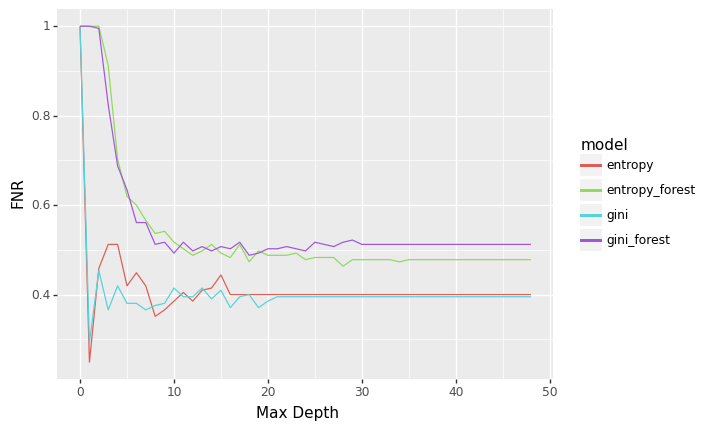

<ggplot: (-9223363267421469373)>

In [ ]:
ggplot(model_fnr) +\
  geom_line(aes(x = "ind", y = "fnr", colour = "model")) +\
  labs(x = "Max Depth", y = "FNR")

What we can conclude from above is that when using **criterion = "entropy" and max_depth = 2**, it produces the best results in terms of FNR.  

There is a obvious trend that the FNR starts to increase after the desired max_depth, this is a signal of over-fitting and that we should avoid building a tree that is too deep.  

The following shows a **Test-Result** of the tree using the above desired parameters.  

In [ ]:
clf = DecisionTreeClassifier(random_state=3101,
                               criterion="gini", 
                               max_depth=2)

# Train Decision Tree Classifer & test on test set
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']

display(cm)
print("\n")
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])

def FNR(y_pred, y_test):
  cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
  FN = cm.iloc[0, 1]
  TP = cm.iloc[1, 1]
  return FN/(FN + TP)
FN = cm.iloc[0, 1]
TP = cm.iloc[1, 1]
print("FNR:", round(FN/(FN + TP), 4))

print("Accuracy:",round(accuracy_score(y_test, y_pred),4))
print('Specificity:', round(specificity,4))
print('Sensitivity',round(recall_score(y_test,y_pred),4))
print('F1-Score:', round(f1_score(y_test,y_pred),4))
print('AUC:',round(roc_auc_score(y_test, y_pred),4))
print("\n")
feature_imp(clf)[:10]

,True Y=0,True Y=1
Predicted Y=0,637,60
Predicted Y=1,127,145




FNR: 0.2927
Accuracy: 0.807
Specificity: 0.8338
Sensitivity 0.7073
F1-Score: 0.608
AUC: 0.7705




[('Frequency', 0.857), ('BMI', 0.143)]

Using the above prediction outcome, it seems to suggest that BMI of the customer & Frequency in our stores seems to be the decision factor that will help us keep our customers with us.  

That being said, the decision tree does not explain the casuality between the variables and churning behaviour.  

From the decision tree logic provided below, we can say that if a customer's frequency score starts to fall below the threshold of 48.5 **and** if his BMI is greater than 2.5, then the customer is likely to churn in the near future.  

Once the high-risk customers are identified, we will be able to deploy targetted marketing to them in the attemp to win then back.  

In [ ]:
tree_rules = export_text(clf, feature_names=list(X_train.columns))
print(tree_rules)

|--- Frequency <= 48.50
|   |--- BMI <= 2.50
|   |   |--- class: 0
|   |--- BMI >  2.50
|   |   |--- class: 1
|--- Frequency >  48.50
|   |--- Frequency <= 58.50
|   |   |--- class: 0
|   |--- Frequency >  58.50
|   |   |--- class: 0



In [ ]:
plt.figure()
tree.plot_tree(clf,filled=True)  
plt.savefig(location + 'decisiontree2.eps',format='eps',bbox_inches = "tight")

In [ ]:
dotfile = open(location + "tree.dot", 'w')
tree.export_graphviz(clf,out_file = dotfile,
                     feature_names=X_train.columns.tolist(),
                     class_names = [str(i) for i in clf.classes_],
                     proportion=False) 
dotfile.close()

# Easiest way to view the dotfile:
# https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn
# 1) exporting it with export_graphviz 
# 2) Open the .dot file in a text editor
# 3) Copy the piece of code and paste it @ webgraphviz.com

# You might wish to use the dot file to visualise the classification

# 5. Recommending based on Income and BMI

Now we will try to make recommendations to customers that have been classified as churned to try to win them back. The strategy will be to recommend them products that non-churned customers bought in hopes that these products are good products that has the power to convince customers to stay. To further personalise these recommendations, we will be grouping the customers based on BMI and income levels to give more targeted recommendations. 

In [ ]:
print(df_decision_tree["Income"].unique())
print(df_decision_tree["BMI"].unique())


[1750 1000 2500 4500 3500 5500]
[1 4 2 3]


## Splitting into 12 clusters

Since we have 6 distinct Income values, we will split them into 3 groups: Low, Medium, and High, represented by 1,2,3.

In [ ]:
df_decision_tree['Income Group'] = df_decision_tree.apply(lambda row: 1  if row["Income"] <=1750 else 3 if row["Income"] >= 4500 else 2, axis=1)

From the levels of BMI and income, we create 12 clusters.

In [ ]:
df_decision_tree['Cluster'] = df_decision_tree.apply(lambda row: row["BMI"] + 4*(row["Income Group"]-1), axis = 1)
df_decision_tree["Cluster"].unique()

array([ 1.,  4.,  2.,  8.,  9.,  5.,  6.,  3., 10., 12., 11.,  7.])

## Average basket size by cluster

We also want to find out what the optimal number of items to recommend to the customer is. We will accomplish this by finding the average basket size per cluster of non churned customers. This will then act as a benchmark to allow us to gauge how many recommendations we should make to our churned customers.

In [ ]:
df_decision_join = df_decision_tree["Cluster"] 
df_hackdata_join =  df_hackdata.set_index('Panel ID').join(df_decision_join)
df_hackdata_join["Panel ID"] = df_hackdata_join.index
df_average_basket_size = df_hackdata_join[["Panel ID", "Category","Date"]].\
                          groupby(['Panel ID', 'Date']).\
                          count().\
                          reset_index().\
                          groupby(['Panel ID']).\
                          mean().\
                          reset_index().\
                          rename(columns = {"Category":"Average Basket Size",'Panel ID': 'ID'})
#df_average_basket_size['ID'] = df_average_basket_size.apply(lambda x: x["ID"].partition(" ")[2], axis=1)
df_average_basket_size = df_average_basket_size.set_index("ID").join(df_decision_join)
df_average_basket_size = df_average_basket_size.\
                          groupby("Cluster").\
                          mean().\
                          round().\
                          reset_index()
df_average_basket_size

,Cluster,Average Basket Size
0,1.0,6.0
1,2.0,6.0
2,3.0,5.0
3,4.0,6.0
4,5.0,6.0
5,6.0,6.0
6,7.0,5.0
7,8.0,5.0
8,9.0,6.0
9,10.0,5.0


## Recommendations by cluster

We will then build a recommendation engine based on cosine similarity to create recommendations for the customers. This recommendation engine will look within the specified customer's cluster to find similar customers and then make recommendations based on what similar customers bought to this customer.

In [ ]:
add1_df = df_decision_tree.drop(df_decision_tree.columns[[0]+[i for i in range(63,83)]], axis = 1)
add1_df = add1_df.merge(df_average_basket_size, on = "Cluster", left_index = True)
add1_df.head()

,Monetary,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,Liquid Milk,MSG,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,Peanut Butter,RTD Coffee,RTD Tea,Rice,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Income Group,Cluster,Average Basket Size
0,30.807778,0.0,0.0,0.0,0.0,19.0,6.0,8.0,49.0,3.0,13.0,3.0,5.0,1.0,0.0,1.0,4.0,32.0,20.0,13.0,0.0,21.0,29.0,7.0,0.0,3.0,11.0,9.0,0.0,32.0,3.0,4.0,0.0,0.0,1.0,11.0,0.0,1.0,2.0,0.0,1.0,1.0,8.0,3.0,0.0,0.0,1.0,0.0,1.0,23.0,3.0,0.0,32.0,13.0,1.0,1.0,0.0,128.0,2.0,3.0,0.0,0.0,1,1.0,6.0
0,45.103788,0.0,0.0,4.0,0.0,53.0,0.0,0.0,9.0,1.0,39.0,0.0,6.0,0.0,0.0,0.0,21.0,104.0,283.0,43.0,0.0,75.0,10.0,10.0,0.0,15.0,0.0,218.0,0.0,6.0,1.0,2.0,0.0,0.0,2.0,91.0,0.0,17.0,0.0,1.0,2.0,9.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,65.0,0.0,0.0,146.0,12.0,3.0,0.0,0.0,270.0,6.0,123.0,0.0,6.0,1,1.0,6.0
0,9.803906,0.0,0.0,8.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0.0,4.0,11.0,3.0,0.0,0.0,0.0,0.0,122.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,162.0,0.0,0.0,0.0,0.0,50.0,3.0,1.0,0.0,0.0,1,1.0,6.0
0,67.267901,0.0,0.0,89.0,3.0,31.0,0.0,0.0,4.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,26.0,2.0,23.0,81.0,9.0,0.0,4.0,0.0,63.0,0.0,107.0,0.0,0.0,0.0,0.0,3.0,16.0,0.0,40.0,0.0,2.0,4.0,10.0,19.0,12.0,0.0,0.0,0.0,0.0,0.0,106.0,10.0,0.0,103.0,106.0,0.0,0.0,0.0,127.0,15.0,7.0,0.0,1.0,1,1.0,6.0
0,67.784906,2.0,0.0,2.0,0.0,108.0,16.0,2.0,39.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,29.0,1.0,45.0,76.0,12.0,161.0,80.0,13.0,0.0,27.0,0.0,86.0,0.0,61.0,18.0,1.0,1.0,1.0,11.0,82.0,0.0,0.0,0.0,0.0,5.0,22.0,2.0,1.0,1.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,84.0,121.0,0.0,0.0,0.0,218.0,24.0,79.0,0.0,0.0,1,1.0,6.0


In [ ]:
cate_list= ['Biscuits',
 'Bouilon',
 'Butter',
 'CSD',
 'Cake',
 'Canned Product',
 'Cereal Beverage',
 'Cereals',
 'Cheese',
 'Choc/Nut Spread',
 'Chocolate',
 'Coconut Milk',
 'Coffee',
 'Condensed/Evap Milk',
 'Cooking Oils',
 'Cooking Sauces',
 'Cordials',
 'Cultured Milk',
 'Drinking Water',
 'Eggs',
 'Flour',
 'Frozen Food',
 'Fruit/Veg Juices',
 'Ice Cream',
 'Instant Noodles',
 'Isotonic Drinks',
 'Jam',
 'Liquid Milk',
 'MSG',
 'Margarine',
 'Milk Powder-Adult',
 'Peanut Butter',
 'RTD Tea',
 'Rice',
 'Salad Dressing',
 'Seasoning Powder',
 'Snack',
 'Soy Milk',
 'Spagetti',
 'Sugar',
 'Tea',
 'Tonic Food Drink',
 'Belacan',
 'Kaya',
 'Yoghurt Drink',
 'Confectionery',
 'Honey',
 'Instant Soup',
 'RTD Coffee',
 'Savoury Spread',
 'Yoghurts',
 'Milk Powder-Kids',
 'Ghee',
 'Baby Cereal',
 'Milk Powder-Infant',
 'Bird Nest',
 'Energy Drinks',
 'Beer',
 'Chicken Essence',
 'Wine',
 'Creamer',
 'Spirits']

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def recommend_profile(panelid):
    panelid = "Panel "+panelid
    cluster = int(add1_df.loc[panelid,"Cluster":])
    df = add1_df[add1_df["Cluster"]==cluster]
    df=df.drop(["Cluster"],axis=1)
    cosinelist = []
    uservec = df.loc[panelid,:].to_numpy()
    indexofuser = df.index.get_loc(panelid)
    for i in range(0,len(df)):
        if i == indexofuser:
            continue
        v = df.iloc[i,:].to_numpy()
        cos = cosine_similarity([uservec], [v])
        cosinelist.append([i,cos[-1][-1]])
        
    cossort=sorted(cosinelist,key = lambda s: s[1],reverse = True)
    
    k=20
    min_k = 5
    np.random.seed(3101)
    np.set_printoptions(suppress=True)
    neighbors=[]
    for j in range(0,min(len(df)-1,k)):
        v = round(df.iloc[cossort[j][0],:],1).to_list()
        neighbors.append(v)
    neighbors = np.array(neighbors)
    ave = np.around(neighbors.mean(axis = 0),decimals = 2)
    return ave

In [ ]:
def recommend_list(id):
    ave = recommend_profile(id).tolist()
    id = "Panel "+ id
    cluster = int(add1_df.loc[id,"Cluster":])
    #basket_size = add1_df.loc[id,"Average Basket Size":]
    #print(basket_size)
    df = add1_df[add1_df["Cluster"]==cluster]
    df=df.drop(["Cluster"],axis=1)
    uservec = df.loc[id,:].to_numpy().tolist()
    
    recommend=[]
    for i in range(len(cate_list)):
        if uservec[i]>1 and ave[i]!=1:
            recommend.append([cate_list[i], ave[i]-1])
    return sorted(recommend, key = lambda x:x[1],reverse=True)

## Value of each non-churned customer

To estimate the success of our program or project potential revenue, we will find out the amount of spending by cluster each customer made in 2018. This would act as a gauge to allow us to value each customer.


In [ ]:
df_hackdata_2018_value = df_hackdata[(df_hackdata["Date"] > '2017-12-31') & (df_hackdata["Date"] < '2019-01-01')][["Panel ID", "Spend"]].\
                          groupby("Panel ID").\
                          sum("Spend")
df_hackdata_2018_value = df_hackdata_2018_value.join(df_decision_tree[["Cluster", "cherned"]])
df_hackdata_2018_value= df_hackdata_2018_value[df_hackdata_2018_value["cherned"]== 0]
df_hackdata_2018_value = df_hackdata_2018_value.groupby("Cluster").\
                        mean("Spend").\
                        drop("cherned",axis = 1)
df_hackdata_2018_value

,Spend
Cluster,
1.0,1658.275000
2.0,1621.163462
3.0,1795.145918
4.0,1678.086207
5.0,1942.554630
6.0,2101.143147
7.0,1909.536975
8.0,1811.914676
9.0,2505.014458


Given the value of each group of customers, we can thus estimate the estimated revenue if we bring a customer back from each group.

# 6. Summary

Why do we focus so much on churned customers and new customers in our report above? Customers who ‘drop off’, which are defined as customers who do not make a purchase in the subsequent year make a total loss of $30,000.  

The more concerning part is that most of these customers made 8 or less transactions with us before they drop off, netting a loss of $18,000 in these 2 years. 


In [ ]:
# create a copy so that the original df is not altered
df_hackdata_tree = df_hackdata.copy()
# only use data 2019 and before

df_cust_pool = df_hackdata_tree[df_hackdata_tree.Date < "2019-01-01"] #take all the old customers
df_cust_2019 = df_hackdata_tree[df_hackdata_tree.Date >= "2019-01-01"] #2019 customers
df_cust_2020 = df_hackdata_tree[df_hackdata_tree.Date >= "2020-01-01"] #2020 customers


df_cust_pool = df_cust_pool['Panel ID'].unique()
df_cust_2019 = df_cust_2019['Panel ID'].unique()
df_cust_2020 = df_cust_2020['Panel ID'].unique()


cherned = set(df_cust_pool) - set(df_cust_2019) #find those who didnt appear in 2019
print('Customers lost in 2019: ' +str(len(cherned)))


c =set(df_cust_2019) - set(df_cust_2020) #find those who didnt appear in 2020 from 2019
print('Customers lost in 2020: ' +str(len(c)))




Customers lost in 2019: 642
Customers lost in 2020: 517


## 6.1 Churned Customer Loss

In this section, we will see the distribution of visits by customers who did not appear in 2020. 




Text(0.5, 1.0, 'Frequency of Visits for Churned')

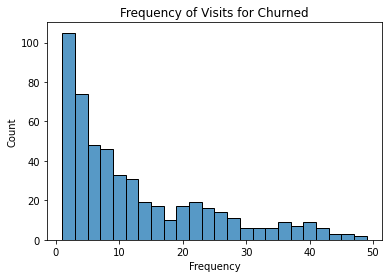

In [ ]:
lister = []
for ids in c:
    lister.append(ids)
    
new_dropped = pd.DataFrame(lister) 

new_dropped = new_dropped.rename(columns = {0:'Panel ID'})
RM = getRFMvalues(df_hackdata_tree[df_hackdata_tree.Date >= "2019-01-01"]).reset_index()
RM=RM.merge(new_dropped, how = 'inner', left_on = 'Panel ID', right_on = 'Panel ID')

sns.histplot(RM.Frequency, bins = 24).set_title('Frequency of Visits for Churned')

A high proportion of customers only visit our supermarket less than 8 times before churning, hence there is a need to retain these new&few customers using our recommendation system in the previous sections.

In [ ]:
new_and_dropped = RM[RM.Frequency <= 8]
print('Monetary Loss for New&Few: $' + str(new_and_dropped['Monetary'].sum())) 
#calculate monetary loss for less than 8 transactions

print('Total Monetary Loss: $' + str(RM.Monetary.sum()))

Monetary Loss for New&Few: $18263.02023809524
Total Monetary Loss: $29726.827468845535


We believe that for the New&Few customers gives us an opportunity to use our decision tree techniques to come up with a recommendation system that optimises a personal basket. If we were to retain 25% of these customers, we can turn our losses into profit. 



In [ ]:
new_and_dropped['Multiply'] = new_and_dropped['Monetary'] * new_and_dropped['Frequency'] 
print('Total Gain: $'+ str(new_and_dropped['Multiply'].sum() * 0.25))

Total Gain: $15150.825
